<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_9/9_3_TermDocumentSentiment_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Approach 1: join to lexicon


---

The traditional lexicon-based approach to sentiment analysis involves using pre-defined dictionaries or lexicons of words that are associated with positive or negative sentiment. This approach determines the sentiment of a piece of text based on the presence and frequency of positive and negative terms in the text. While this approach is simple and effective, it does not take into account nuances of language, term order or sarcasm.


One way to implement the lexicon-based approach is to use a pre-built sentiment lexicons:

We are going to take a look at 3: 

- NRC: contains over 140,000 English words and phrases, each of which is labeled with **one or more** sentiment categories (such as positive, negative, or fear).

- AFINN: contains 2,477 English terms, each term is given a sentiment score between -5 (most negative) and 5 (most positive)

- BING : Contains approximately 6,800 English words and phrases that are labeled as either positive or negative.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# standard libries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import string
import re

# text libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud


# Download our Parser, stopwords, and sentiment mapping


---



In [ ]:
# download nltk datasets
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Make a stopwords dataframe

In [ ]:
# Define the stop words to remove
stop_words = set(stopwords.words('english'))

# Convert the set to a DataFrame
stopwords_df = pd.DataFrame(list(stop_words), columns=['stopword'])
print("There are {} words in the stopword list here is a sample: \n {}".format(stopwords_df.shape[0],list(stop_words)[0:4]))


There are 179 words in the stopword list here is a sample: 
 ["hadn't", "mightn't", "needn't", 'up']


# Sentiment Datasets


---

Bing, AFINN, and NRC are popular sentiment lexicons used in NLP projects to determine the sentiment of terms or phrases.

- Bing is a sentiment lexicon developed by Microsoft that assigns a score of either 'positive', 'negative', or 'neutral' to each word or phrase in the lexicon. 

- AFINN is a sentiment lexicon developed by Finn Årup Nielsen that assigns a score to each word in the lexicon ranging from -5 (most negative) to +5 (most positive). It is a simple and easy-to-use sentiment lexicon that is often used as a baseline for sentiment analysis tasks.

- NRC (National Research Council) is a sentiment lexicon developed by Saif Mohammad and Peter Turney that assigns scores to words based on eight different emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, and trust. It is useful for tasks that require a more nuanced understanding of sentiment.

let's download them! 


In [ ]:
afinn = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/Afinn.csv", encoding='ISO-8859-1')
print(afinn.head())
bing = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/Bing.csv", encoding='ISO-8859-1')
print(bing.head())
nrc = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/NRC.csv", encoding='ISO-8859-1')
print(nrc.head())


        word  value
0    abandon     -2
1  abandoned     -2
2   abandons     -2
3   abducted     -2
4  abduction     -2
         word sentiment
0     2-faces  negative
1    abnormal  negative
2     abolish  negative
3  abominable  negative
4  abominably  negative
        word sentiment
0     abacus     trust
1    abandon      fear
2    abandon  negative
3    abandon   sadness
4  abandoned     anger


# Data


---

Today's data comes from Yelp! we have a bunch of reviews of coffee shops and resturants in Austin TX. Let's dive in and take a look! 

In [ ]:
yelp = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/ratings_and_sentiments.csv", encoding="ISO-8859-1")
yelp.head(5)


,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,seating_sent,price_sent,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,0.0,0.0,0,0.0,1.0,3,0,0.0,0.0,0.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,0.0,0.0,0,0.0,0.0,0,2,0.0,0.0,0.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,3.0,0.0,0,0.0,0.0,-1,2,0.0,0.0,0.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,-1.0,-1.0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,0.0,0.0,3,0.0,0.0,0,0,0.0,0.0,0.0


## Extract the Date and convert it


---

Each review contains the date as the first character string (word) for example "11/25/2016 1 check-in Love love loved the vibe" we want to extract that date into a new column called review_date and cast it to a date data type. 

> `.str.split() is used to split each string in a colun into a *list* of substrings based on a specified separator (sep = " ")`


In [ ]:
yelp["review_date"] = yelp["review_text"].str.split().str[0]
yelp["review_date"] = pd.to_datetime(yelp["review_date"] )
yelp.head(5)

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,...,price_sent,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent,review_date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,...,0.0,0,0.0,1.0,3,0,0.0,0.0,0.0,2016-11-25
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,...,0.0,0,0.0,0.0,0,2,0.0,0.0,0.0,2016-12-02
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,...,0.0,0,0.0,0.0,-1,2,0.0,0.0,0.0,2016-11-30
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,...,-1.0,0,0.0,0.0,0,0,0.0,0.0,0.0,2016-11-25
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,...,0.0,3,0.0,0.0,0,0,0.0,0.0,0.0,2016-12-03


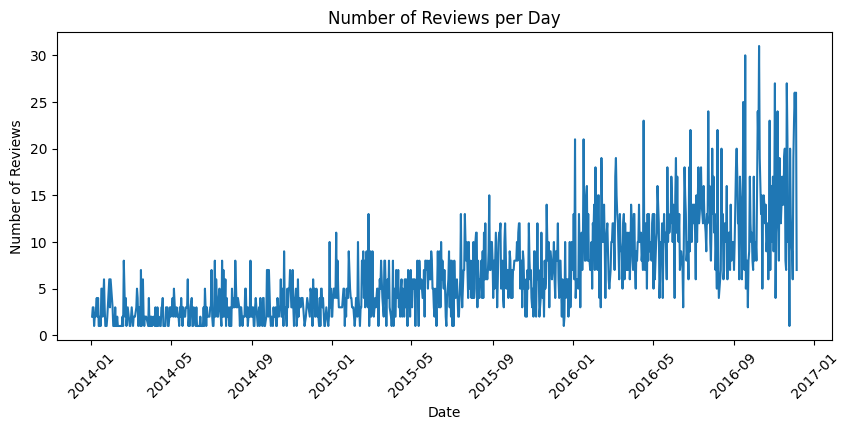

In [ ]:
res1 = (yelp
        .groupby("review_date")
        .agg(review_count = ("review_text","count"))
        .reset_index()
        .query("review_date > '2014-01-01'")
)

# set the figure size and title
plt.figure(figsize=(10, 4))
sns.lineplot(data=res1, x="review_date", y="review_count")
plt.title("Number of Reviews per Day")
# set the x and y axis labels
plt.xlabel("Date")
plt.ylabel("Number of Reviews")

# rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# show the plot
plt.show()

# Clean up Reviews



---

we know that the first word in the review is the date, sometimes there is a count and number of check-in or check-ins ex: "1 check-in" or "2 check-ins" are embeded in the review. lets remove these! 



In [ ]:
# create a mask to check if 'check-in' or 'check-ins' is in the string
mask = yelp['review_text'].str.contains('check-in|check-ins')

# replace null values in 'review_text' with '2023-01-01 no-review'
yelp['review_text'] = yelp['review_text'].fillna('2023-01-01 no-review')

# chain the methods to remove the first three words if the mask is True, otherwise remove just the first word
yelp['review_text_clean'] = (yelp['review_text']
                             .apply(lambda x: ' '.join(x.split()[3:]) if (mask.any() and x is not None) else x.split()[1] if x is not None else None))

yelp.head(10)

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,...,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent,review_date,review_text_clean
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,...,0,0.0,1.0,3,0,0.0,0.0,0.0,2016-11-25,Love love loved the vibe! Every corner of the ...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,...,0,0.0,0.0,0,2,0.0,0.0,0.0,2016-12-02,"Date Night: Austin, vibe in Austin BEAUTIFUL!!..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,...,0,0.0,0.0,-1,2,0.0,0.0,0.0,2016-11-30,Listed in food seating I loved the eclectic an...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0.0,2016-11-25,vibe! Good drinks Nice seating However... Just...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,...,3,0.0,0.0,0,0,0.0,0.0,0.0,2016-12-03,They are location within the Northcross mall s...
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4.0 star rating,4.0,HIGH,1.0,0.0,2,0.0,0.0,...,0,0.0,0.0,0,0,0.0,-1.0,0.0,2016-11-20,Very cute cafe! I think from the moment I step...
6,The Factory - Cafe With a Soul,"10/27/2016 2 check-ins Listed in ""Nuptial Cof...",4.0 star rating,4.0,HIGH,1.0,3.0,0,0.0,0.0,...,0,0.0,0.0,1,1,1.0,0.0,0.0,2016-10-27,"Listed in ""Nuptial Coffee Bliss!"", Anderson La..."
7,The Factory - Cafe With a Soul,11/2/2016 2 check-ins Love this place! 5 sta...,5.0 star rating,5.0,HIGH,1.0,0.0,1,0.0,1.0,...,1,1.0,0.0,-1,0,0.0,0.0,0.0,2016-11-02,Love this place! 5 stars for cleanliness 5 sta...
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3.0 star rating,3.0,LOW,0.0,3.0,3,0.0,0.0,...,0,0.0,0.0,0,2,0.0,1.0,0.0,2016-10-25,"Ok, let's try this approach... Pros: vibe seat..."
9,The Factory - Cafe With a Soul,11/10/2016 3 check-ins This place has been sh...,5.0 star rating,5.0,HIGH,1.0,3.0,1,0.0,0.0,...,0,0.0,0.0,1,0,0.0,0.0,0.0,2016-11-10,This place has been shown on my social media f...


## Sentiment via Joins


---



In [ ]:
# split the review text into individual words and explode the resulting Series of lists
yelp_terms = (yelp[["coffee_shop_name","review_date","review_text_clean"]]
              .assign(review_text=yelp['review_text_clean']
                     .str.lower()
                     .apply(lambda x: re.sub('\s+', ' ', x.translate(str.maketrans('', '', string.punctuation)).strip()))
                     .str.split())
             .explode('review_text')
             .reset_index(drop=True)
             .drop("review_text_clean",axis=1)
             .dropna()
             .rename(columns={"review_text":"term"})
             )
yelp_terms.head(10)


,coffee_shop_name,review_date,term
0,The Factory - Cafe With a Soul,2016-11-25,love
1,The Factory - Cafe With a Soul,2016-11-25,love
2,The Factory - Cafe With a Soul,2016-11-25,loved
3,The Factory - Cafe With a Soul,2016-11-25,the
4,The Factory - Cafe With a Soul,2016-11-25,vibe
5,The Factory - Cafe With a Soul,2016-11-25,every
6,The Factory - Cafe With a Soul,2016-11-25,corner
7,The Factory - Cafe With a Soul,2016-11-25,of
8,The Factory - Cafe With a Soul,2016-11-25,the
9,The Factory - Cafe With a Soul,2016-11-25,coffee


# TErm FReq w. JunK


---



In [ ]:
term_freq_w_junk = (yelp_terms
            .groupby("term")
            .size()
            .reset_index()
            .rename(columns={0: "freq"})
            .sort_values("freq", ascending=False)
            .dropna()
            .reset_index(drop=True)
            )
term_freq_w_junk.head(10)

,term,freq
0,the,34465
1,and,26615
2,a,22599
3,i,19485
4,to,17103
5,coffee,15352
6,of,12535
7,is,11742
8,food,10674
9,was,9604


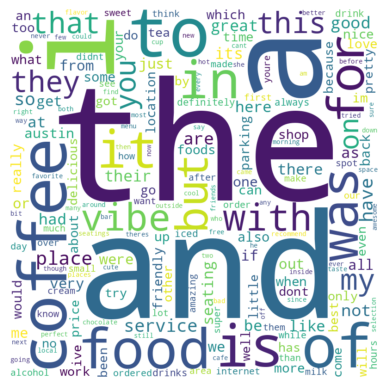

In [ ]:
# Create a dictionary of terms and frequencies
term_freq_w_junk_dict = dict(zip(term_freq_w_junk['term'], term_freq_w_junk['freq']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(term_freq_w_junk_dict)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Term Freq without Junk


---

Here we'll use a join to the stopwords dataframe to remove junk words. we may still need to do further cleaning but this gets it started. 

In [ ]:
# Remove stop words and excludes from the DataFrame
term_freq_wo_junk = (term_freq_w_junk
             .merge(stopwords_df, how='left', left_on='term', right_on='stopword')
             .query("stopword.isna()")
             .drop(['stopword'], axis=1)
            )

term_freq_wo_junk.head(10)

,term,freq
5,coffee,15352
8,food,10674
14,vibe,6500
22,place,5157
25,service,4473
28,good,4142
29,great,3688
35,seating,3165
37,like,3061
48,get,2420


## Join based Sentiments


---

- afinn: we'll join afinn then visualize wordcloud by value of sentiment driving color and term frequency.
- bing we'll join to bing and visualize wordcloud by positive negative 
- nrc we'll join to nrc and visualize the wordcloud by sentiment 

# AFINN


---



In [ ]:
afinn_sentiment = ( term_freq_wo_junk
                    .merge(afinn, how='left', left_on='term', right_on='word')
                    #.query("not value.isna()")
)
afinn_sentiment.head()

,term,freq,word,value
0,coffee,15352,NaN,NaN
1,food,10674,NaN,NaN
2,vibe,6500,NaN,NaN
3,place,5157,NaN,NaN
4,service,4473,NaN,NaN


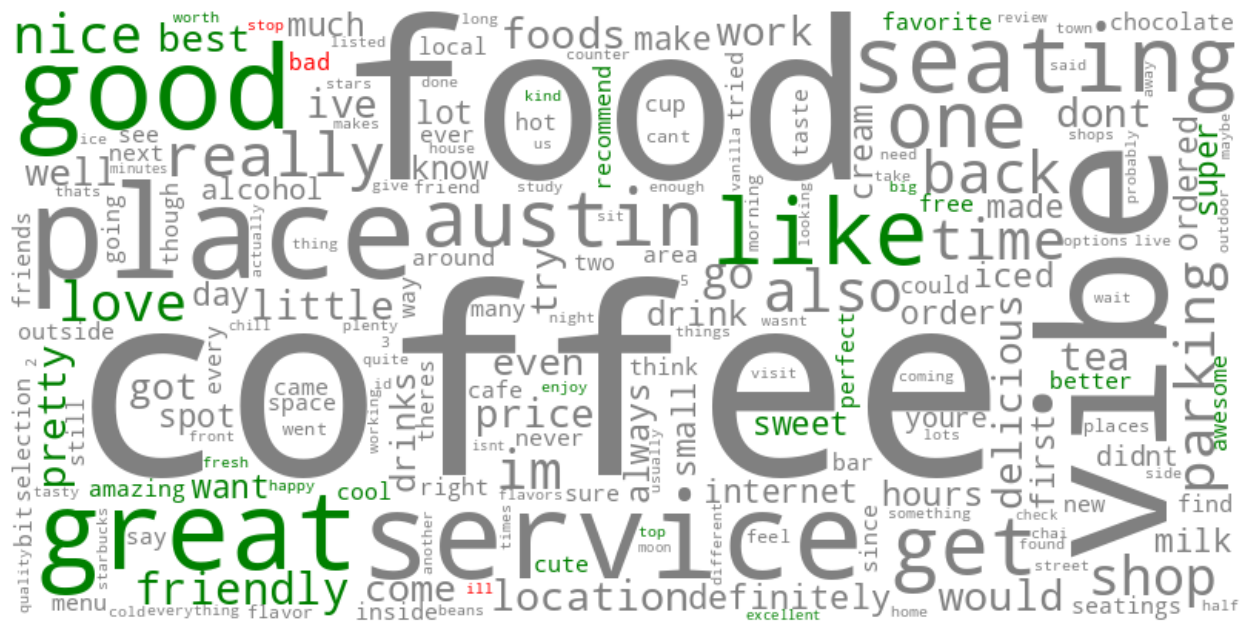

In [ ]:
# create a dictionary of term frequency counts
freq_dict = dict(zip(afinn_sentiment['term'], afinn_sentiment['freq']))

# create a dictionary of sentiment scores
sentiment_dict = dict(zip(afinn_sentiment['term'], afinn_sentiment['value']))

# create a color function that maps sentiment scores to colors
def get_color(word, *args, **kwargs):
    sentiment_score = sentiment_dict.get(word)
    if sentiment_score is not None:
        if sentiment_score > 0:
            return 'green'
        elif sentiment_score < 0:
            return 'red'
        else:
            return 'gray'
    else:
        return 'black'

# create the word cloud object
wordcloud = WordCloud(background_color='white', width=800, height=400, color_func=get_color).generate_from_frequencies(freq_dict)

# display the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

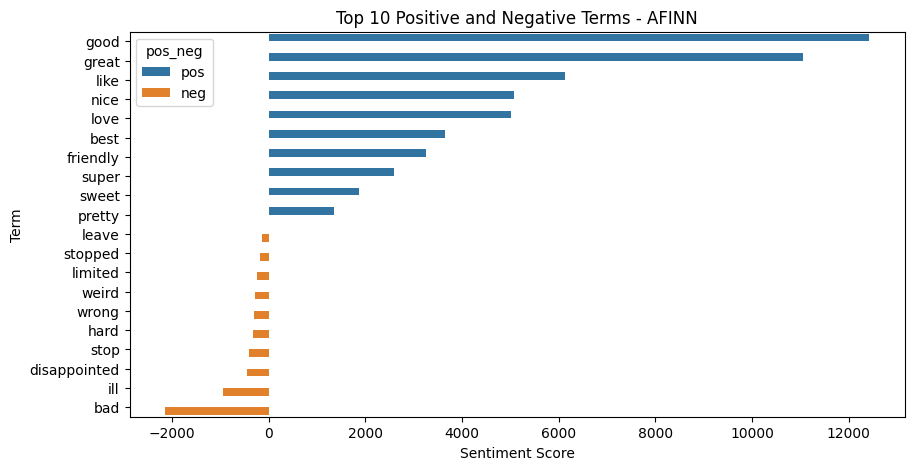

In [ ]:
import numpy as np
# Get the top 10 positive terms based on frequency counts
top_pos_terms = afinn_sentiment.query("value > 0").sort_values('freq', ascending=False).head(10)

# Get the top 10 negative terms based on frequency counts
top_neg_terms = afinn_sentiment.query("value < 0").sort_values('freq', ascending=False).head(10)

res1 = pd.concat([top_pos_terms, top_neg_terms])
res1["sent_score"] = res1["freq"] * res1["value"] 
res1["pos_neg"] = np.where(res1["sent_score"] > 0, "pos", "neg")
res1 = res1.sort_values("sent_score", ascending=False)  # sort by sent_score
plt.figure(figsize=(10, 5))
sns.barplot(data=res1, x="sent_score", y="term", hue="pos_neg")
plt.xlabel("Sentiment Score")
plt.ylabel("Term")
plt.title("Top 10 Positive and Negative Terms - AFINN")
plt.show()


# BING

In [ ]:
bing_sentiment = ( term_freq_wo_junk
                    .merge(bing, how='left', left_on='term', right_on='word')
                    #.query("not sentiment.isna()")
)
bing_sentiment["bing_ind"] = np.where(bing_sentiment["sentiment"] == "positive",1,-1)
bing_sentiment["bing_score"] =bing_sentiment["bing_ind"] * bing_sentiment["freq"]
bing_sentiment.head()

,term,freq,word,sentiment,bing_ind,bing_score
0,coffee,15352,NaN,NaN,-1,-15352
1,food,10674,NaN,NaN,-1,-10674
2,vibe,6500,NaN,NaN,-1,-6500
3,place,5157,NaN,NaN,-1,-5157
4,service,4473,NaN,NaN,-1,-4473


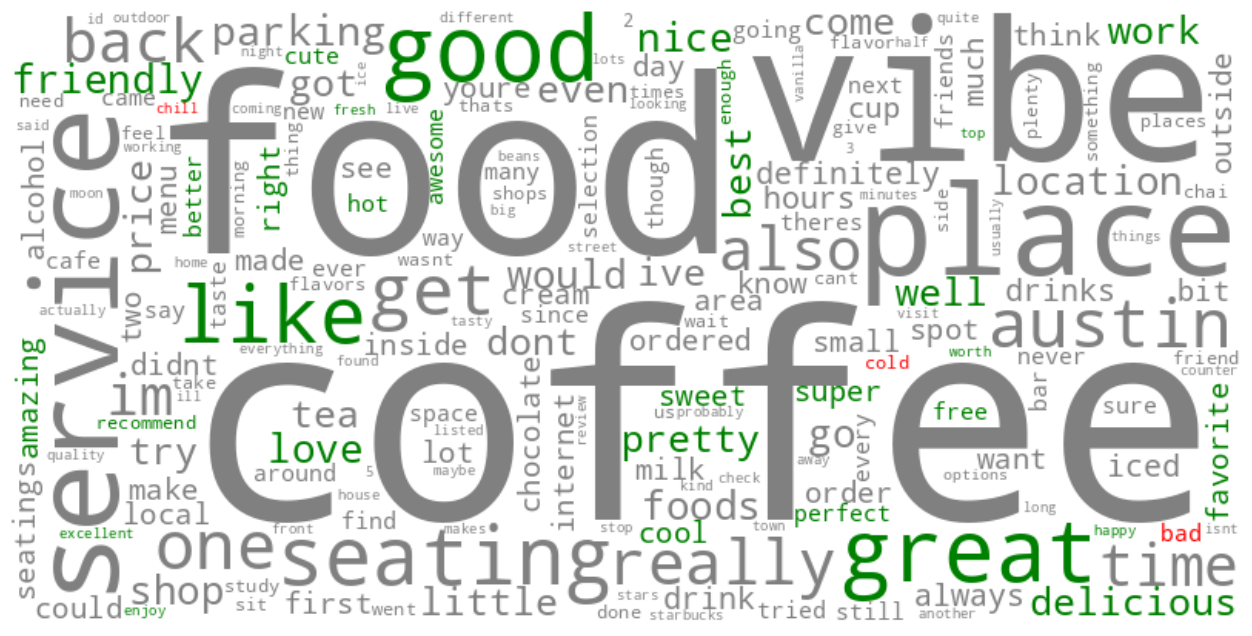

In [ ]:
# Create a dictionary of term frequency counts
freq_dict = dict(zip(bing_sentiment['term'], bing_sentiment['freq']))

# Create a dictionary of sentiment scores
sentiment_dict = dict(zip(bing_sentiment['term'], bing_sentiment['sentiment']))

# Define color function that maps sentiment scores to colors
def get_color(word, *args, **kwargs):
    sentiment = sentiment_dict.get(word)
    if sentiment is not None:
        if sentiment == 'positive':
            return 'green'
        elif sentiment == 'negative':
            return 'red'
        else:
            return 'gray'
    else:
        return 'black'

# Create WordCloud object with frequency count and color function
wordcloud = WordCloud(background_color='white', width=800, height=400, color_func=get_color).generate_from_frequencies(freq_dict)

# Display the WordCloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

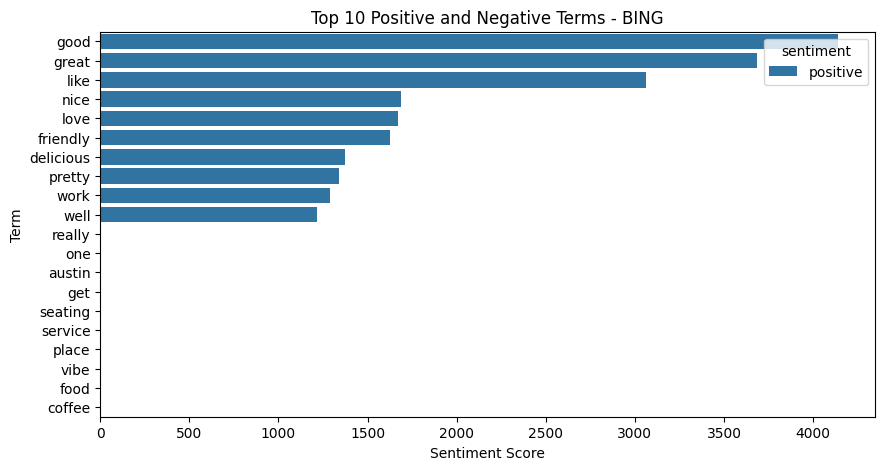

In [ ]:
# Get the top 10 positive terms based on frequency counts
top_pos_terms = bing_sentiment.query("bing_score > 0").sort_values('freq', ascending=False).head(10)

# Get the top 10 negative terms based on frequency counts
top_neg_terms = bing_sentiment.query("bing_score < 0").sort_values('freq', ascending=False).head(10)

res1 = pd.concat([top_pos_terms, top_neg_terms])
#res1["sent_score"] = res1["freq"] * res1["value"] 
res1 = res1.sort_values("bing_score", ascending=False)  # sort by sent_score
plt.figure(figsize=(10, 5))
sns.barplot(data=res1, x="bing_score", y="term", hue="sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Term")
plt.title("Top 10 Positive and Negative Terms - BING")
plt.show()

# NRC 
---
similar but different! 

In [ ]:
nrc_sentiment = ( term_freq_wo_junk
                    .merge(nrc, how='left', left_on='term', right_on='word')
                    #.query("not sentiment.isna()")
                    .query("sentiment.isin(['joy','anger','neutral'])")
)
nrc_sentiment.head()

,term,freq,word,sentiment
1,food,10674,food,joy
8,good,4142,good,joy
26,love,1669,love,joy
29,friendly,1626,friendly,joy
39,delicious,1372,delicious,joy


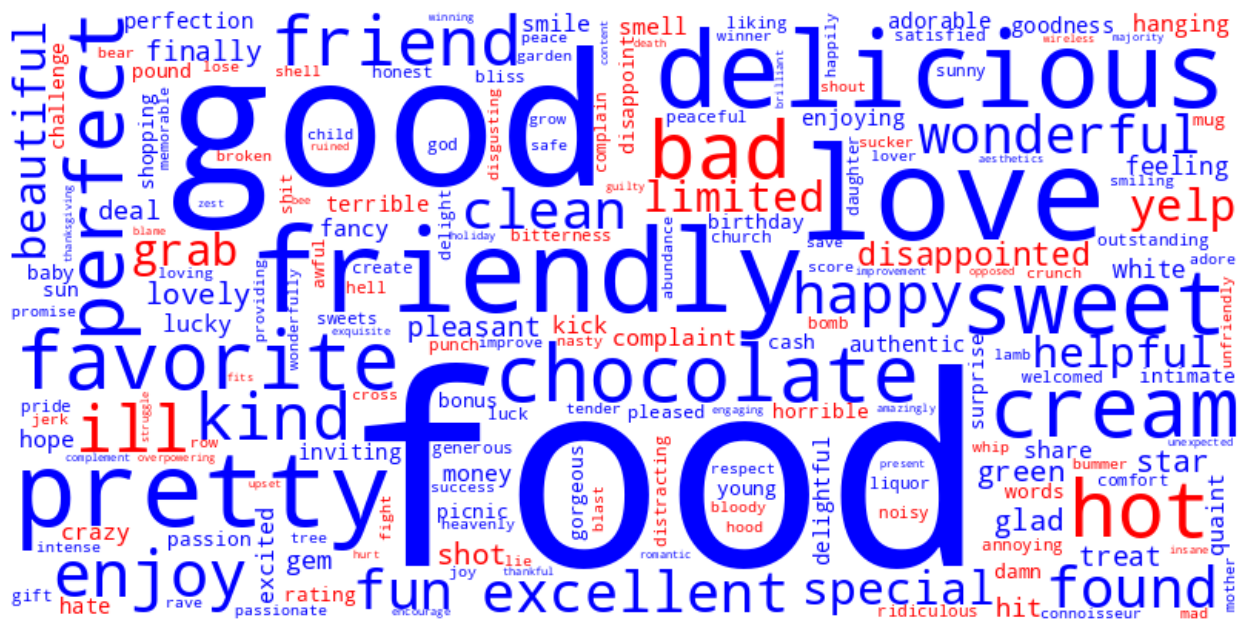

In [ ]:
# Create a dictionary of term frequency counts
freq_dict = dict(zip(nrc_sentiment['term'], nrc_sentiment['freq']))

# Create a dictionary of sentiment scores
sentiment_dict = dict(zip(nrc_sentiment['term'], nrc_sentiment['sentiment']))

# Define color function that maps sentiment scores to colors
def get_color(word, *args, **kwargs):
    sentiment = sentiment_dict.get(word)
    if sentiment is not None:
        if sentiment == 'anger':
            return 'red'
        elif sentiment == 'joy':
            return 'blue'
        else:
            return 'gray'
    else:
        return 'black'

# Create WordCloud object with frequency count and color function
wordcloud = WordCloud(background_color='white', width=800, height=400, color_func=get_color).generate_from_frequencies(freq_dict)

# Display the WordCloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()